In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d iamsouravbanerjee/animal-image-dataset-90-different-animals

mkdir: cannot create directory ‘/root/.kaggle’: File exists
animal-image-dataset-90-different-animals.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/animal-image-dataset-90-different-animals.zip')
zip_ref.extractall()
zip_ref.close()

In [22]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.utils import generate_df, DatasetHandler, ModelEvaluator

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense,
                                     Input,
                                     Dropout,
                                     BatchNormalization,
                                     RandomFlip,
                                     RandomRotation,
                                     RandomZoom,
                                     RandomContrast)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import EfficientNetB3, efficientnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (Callback,
                                        EarlyStopping,
                                        ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras import mixed_precision

In [ ]:
if tf.__version__ != '2.9.0':
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.9.0

Found existing installation: tensorflow 2.9.0
Uninstalling tensorflow-2.9.0:
  Successfully uninstalled tensorflow-2.9.0
  Using cached tensorflow-2.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.9.0 which is incompatible.


In [ ]:
print(tf.__version__)

2.9.0


In [ ]:
data_dir = '/content/animals/animals'

dataset = generate_df(data_dir)

dataset.head()

,imgpath,labels
0,/content/animals/animals/cow/82f107f486.jpg,cow
1,/content/animals/animals/cow/0bc9244dbf.jpg,cow
2,/content/animals/animals/cow/3e7a900953.jpg,cow
3,/content/animals/animals/cow/3f5c04a48c.jpg,cow
4,/content/animals/animals/cow/8e5ebe9684.jpg,cow


In [ ]:
dataset['labels'].value_counts()

labels
cow          60
hornbill     60
jellyfish    60
possum       60
seahorse     60
             ..
moth         60
fly          60
rat          60
dragonfly    60
bison        60
Name: count, Length: 90, dtype: int64

In [ ]:
data_handler = DatasetHandler(dataset)

train_df, val_df, test_df = data_handler.split_data(dataset, train_size = 0.7, val_size = 0.7, random_state = 0)

data_handler.dataset_info(train_df)

data_handler.dataset_info(val_df)

data_handler.dataset_info(test_df)

----------Train-------------
                                             imgpath     labels
0    /content/animals/animals/gorilla/33cd8e571b.jpg    gorilla
1       /content/animals/animals/deer/6b4c626340.jpg       deer
2     /content/animals/animals/oyster/ef5adbbcec.jpg     oyster
3     /content/animals/animals/parrot/4c26cd72e2.jpg     parrot
4  /content/animals/animals/orangutan/5ba2caad9d.jpg  orangutan
(3779, 2)
--------Validation----------
                                             imgpath       labels
0  /content/animals/animals/hummingbird/7f96565dc...  hummingbird
1     /content/animals/animals/badger/315c444990.jpg       badger
2  /content/animals/animals/grasshopper/6ecae4871...  grasshopper
3  /content/animals/animals/hummingbird/159aa872d...  hummingbird
4        /content/animals/animals/owl/29b340159d.jpg          owl
(1134, 2)
----------Test--------------
                                            imgpath    labels
0      /content/animals/animals/deer/73ab2632db.jpg

In [ ]:
%%time

BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

generator = ImageDataGenerator(preprocessing_function = efficientnet.preprocess_input)

train_images = generator.flow_from_dataframe(dataframe = train_df,
                                             x_col = 'imgpath',
                                             y_col = 'labels',
                                             target_size = IMAGE_SIZE,
                                             color_mode = 'rgb',
                                             class_mode = 'categorical',
                                             batch_size = BATCH_SIZE,
                                             shuffle = True,
                                             seed = 0)

val_images = generator.flow_from_dataframe(dataframe = val_df,
                                           x_col = 'imgpath',
                                           y_col = 'labels',
                                           target_size = IMAGE_SIZE,
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

test_images = generator.flow_from_dataframe(dataframe = test_df,
                                            x_col = 'imgpath',
                                            y_col = 'labels',
                                            target_size = IMAGE_SIZE,
                                            color_mode = 'rgb',
                                            class_mode = 'categorical',
                                            batch_size = BATCH_SIZE,
                                            shuffle = False)

Found 3779 validated image filenames belonging to 90 classes.
Found 1134 validated image filenames belonging to 90 classes.
Found 487 validated image filenames belonging to 90 classes.
CPU times: user 55.7 ms, sys: 17.5 ms, total: 73.2 ms
Wall time: 79 ms


In [ ]:
%%time

pretrained_model = EfficientNetB3(input_shape = IMAGE_SIZE + (3,),
                                  include_top = False,
                                  weights = 'imagenet',
                                  pooling = 'max')

for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

43941136/43941136 [==============================] - 2s 0us/step
CPU times: user 3.2 s, sys: 324 ms, total: 3.53 s
Wall time: 6.89 s


In [ ]:
output_classes = len(set(train_images.classes))

augment = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.15),
    RandomZoom(0.15),
    RandomContrast(0.15),
], name = 'augment_layer')

inputs = Input(shape = IMAGE_SIZE + (3,), name = 'input_layer')
x = augment(inputs)
pretrain = pretrained_model(x)
x = Dense(256, activation = 'relu')(pretrain)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
outputs = Dense(output_classes, activation = 'softmax', dtype = tf.float32, name = 'output_layer')(x)

model = Model(inputs = inputs, outputs = outputs)

model.compile(optimizer = Adam(learning_rate = 1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augment_layer (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [15]:
%%time

history = model.fit(train_images,
                    steps_per_epoch = len(train_images),
                    validation_data = val_images,
                    validation_steps = len(val_images),
                    epochs = 10,
                    callbacks = [
                        EarlyStopping(monitor = 'val_loss',
                                      patience = 3,
                                      restore_best_weights = True),
                        ReduceLROnPlateau(monitor = 'val_loss',
                                          factor = 0.2,
                                          patience = 2,
                                          mode = 'min')
                    ])

Epoch 1/10


237/237 [==============================] - 677s 3s/step - loss: 4.5294 - accuracy: 0.0804 - val_loss: 2.7849 - val_accuracy: 0.4180 - lr: 1.0000e-04
Epoch 2/10
237/237 [==============================] - 669s 3s/step - loss: 2.9249 - accuracy: 0.3493 - val_loss: 1.6429 - val_accuracy: 0.6790 - lr: 1.0000e-04
Epoch 3/10
237/237 [==============================] - 631s 3s/step - loss: 2.1426 - accuracy: 0.5181 - val_loss: 1.1956 - val_accuracy: 0.7593 - lr: 1.0000e-04
Epoch 4/10
237/237 [==============================] - 656s 3s/step - loss: 1.7082 - accuracy: 0.6234 - val_loss: 0.9310 - val_accuracy: 0.7989 - lr: 1.0000e-04
Epoch 5/10
237/237 [==============================] - 629s 3s/step - loss: 1.4137 - accuracy: 0.6798 - val_loss: 0.7979 - val_accuracy: 0.8272 - lr: 1.0000e-04
Epoch 6/10
237/237 [==============================] - 645s 3s/step - loss: 1.2452 - accuracy: 0.7139 - val_loss: 0.6762 - val_accuracy: 0.8510 - lr: 1.0000e-04
Epoch 7/10
237/237 [==============================]

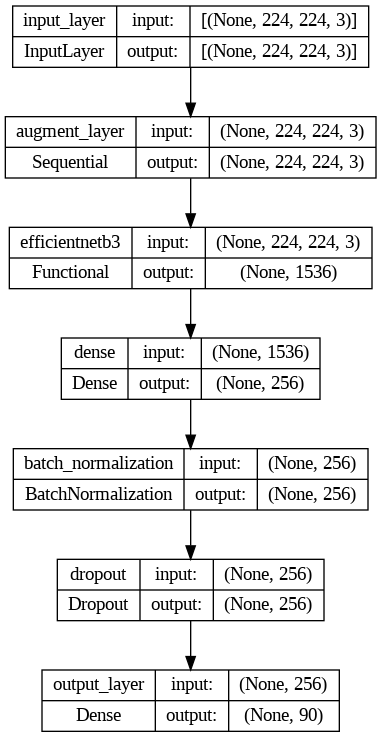

In [21]:
plot_model(model, to_file = 'animal_classification_model_1.png', show_shapes = True, show_layer_names = True)

In [16]:
test_metrics = ModelEvaluator(test_images, model)

test_metrics.classification_report()

31/31 [==============================] - 61s 2s/step
F1 Score: 0.8632657695093197
                precision    recall  f1-score   support

      antelope       0.86      0.86      0.86         7
        badger       1.00      0.83      0.91         6
           bat       0.80      0.67      0.73         6
          bear       0.71      1.00      0.83         5
           bee       1.00      1.00      1.00         2
        beetle       1.00      0.83      0.91         6
         bison       1.00      0.67      0.80         3
          boar       0.71      1.00      0.83         5
     butterfly       1.00      1.00      1.00         6
           cat       0.75      1.00      0.86         3
   caterpillar       1.00      0.83      0.91         6
    chimpanzee       1.00      1.00      1.00         5
     cockroach       0.83      1.00      0.91         5
           cow       0.80      0.57      0.67         7
        coyote       1.00      0.71      0.83         7
          crab       

In [17]:
test_metrics.accuracy()

    Test Loss: 0.47706
Test Accuracy: 86.86%


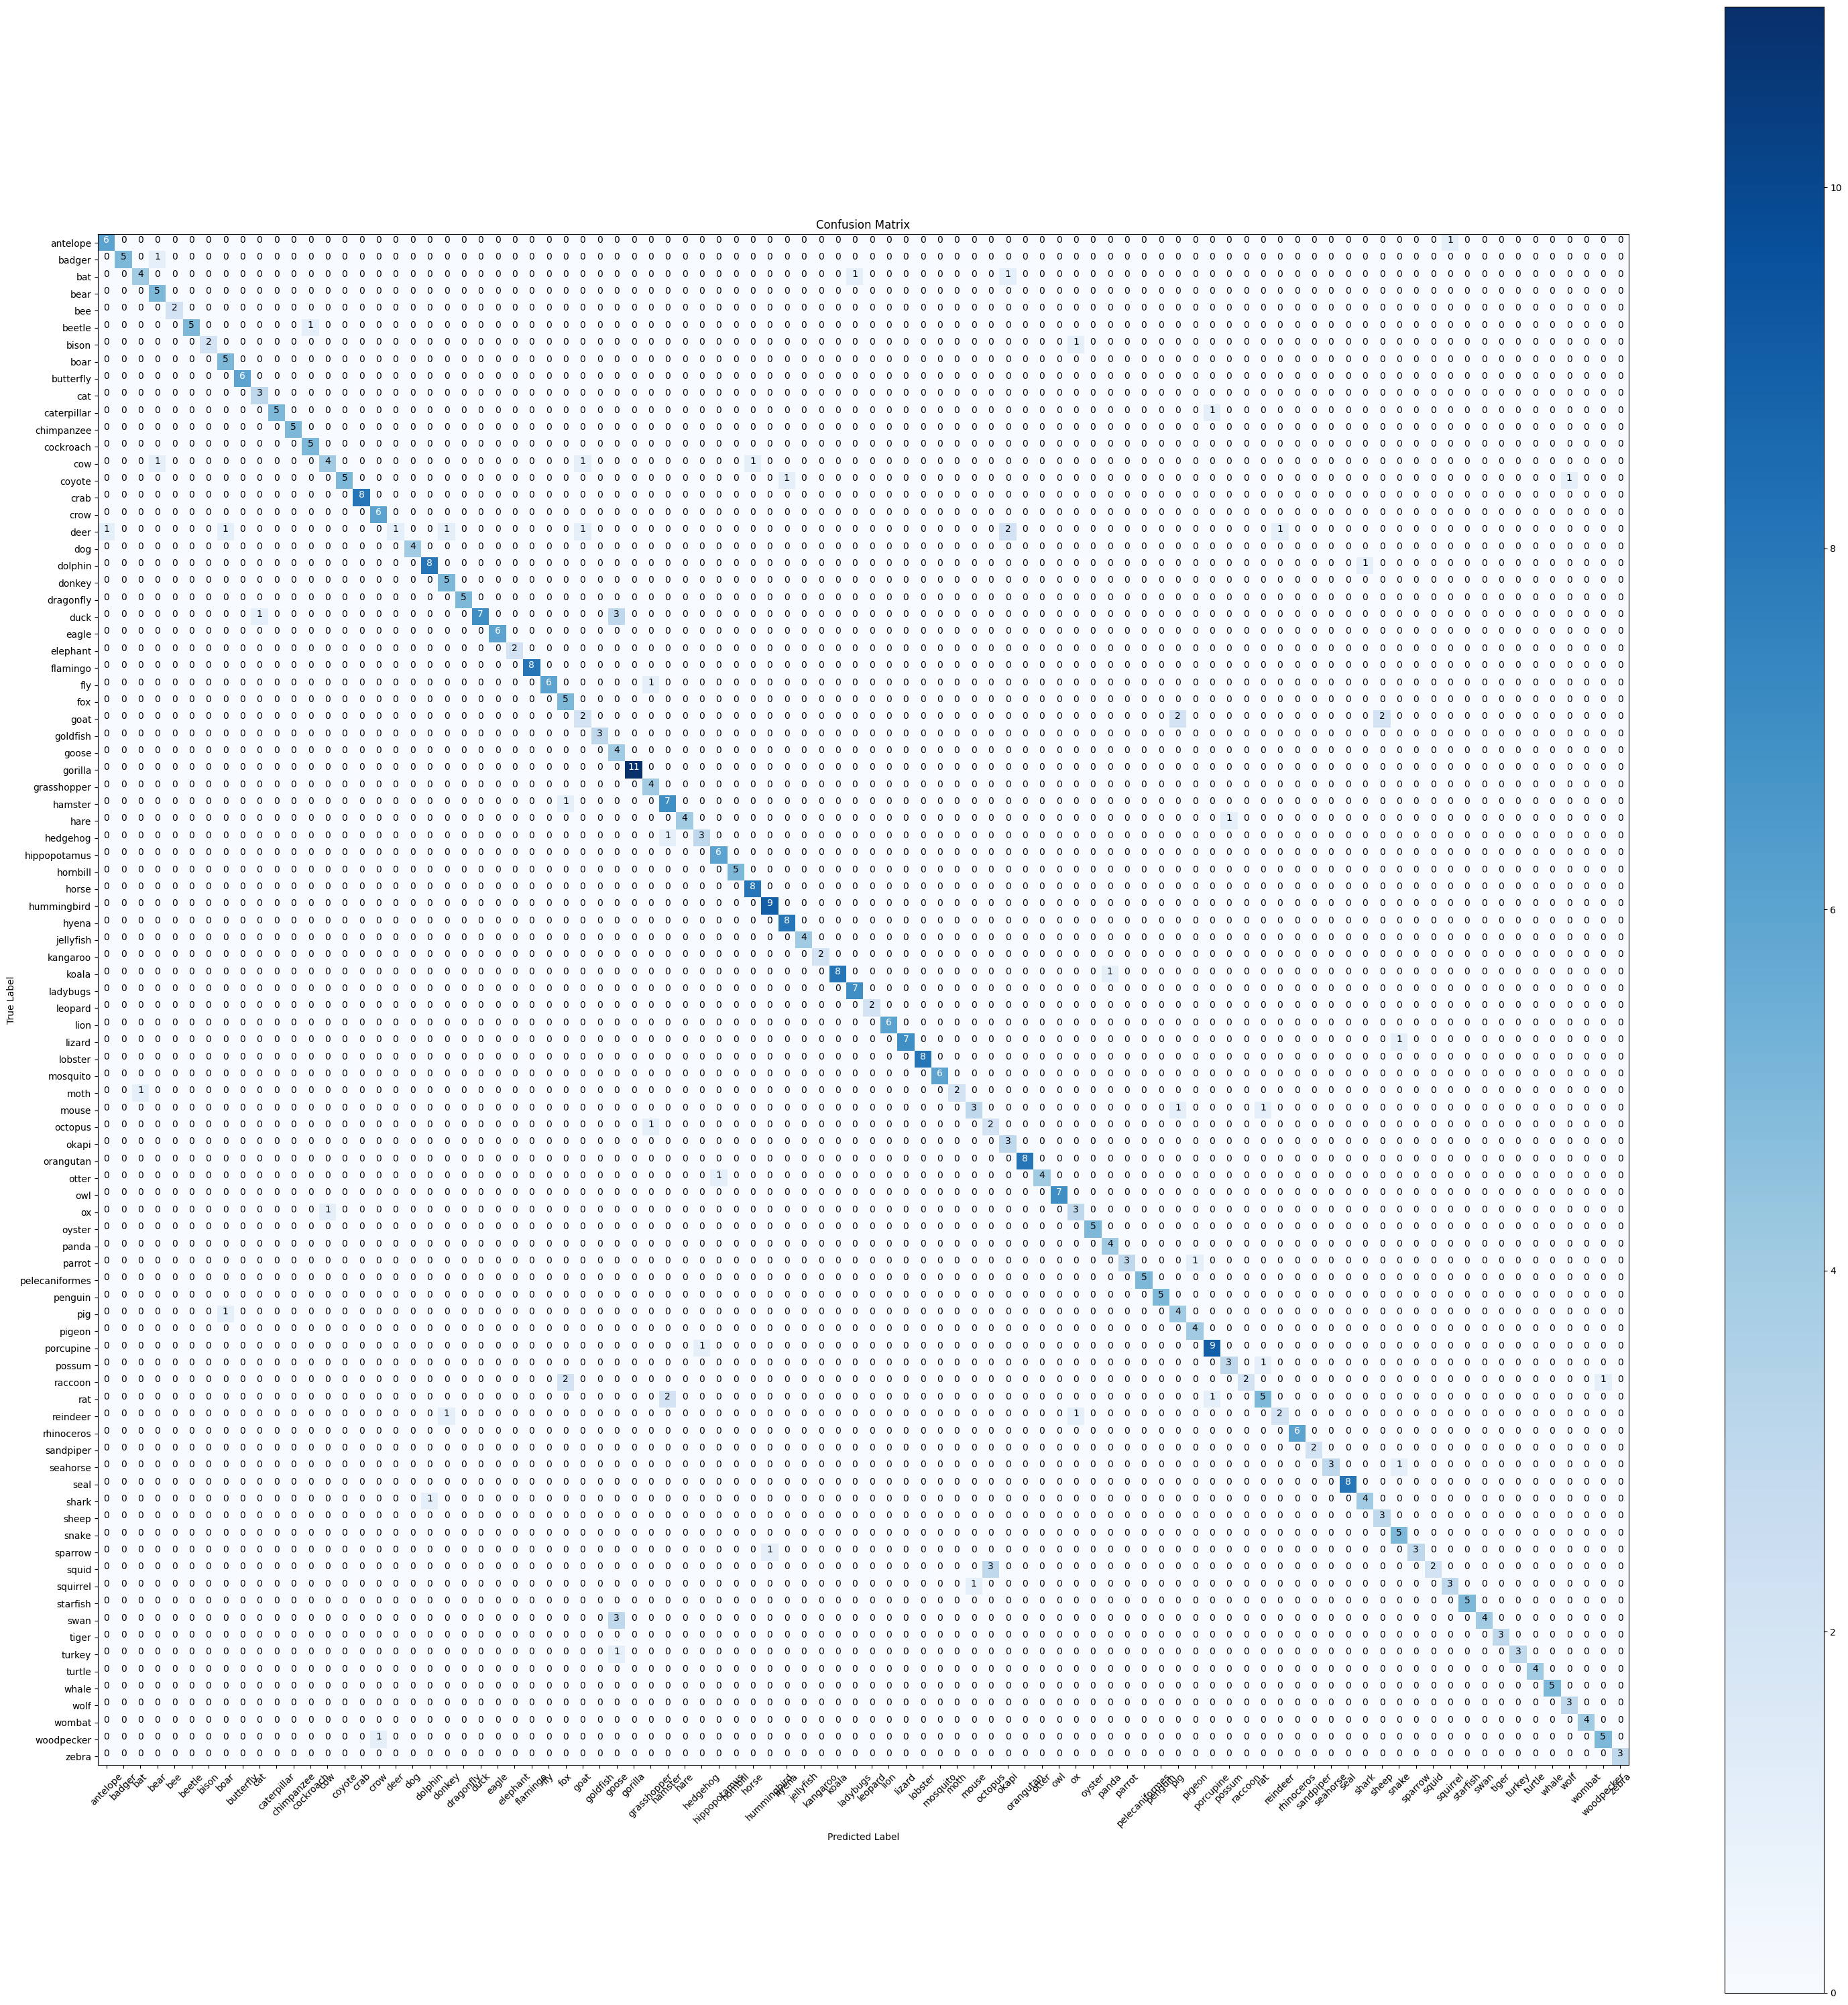

In [19]:
test_metrics.plot_confusion_matrix()

In [23]:
model.save('/content/animal_classification.h5')

In [25]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify file path
file_path = '/content/drive/My Drive/animal_classification.h5'

# Write content to file
content = "This is the content of my file."
with open(file_path, 'w') as f:
    f.write(content)

print("File saved successfully to Google Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File saved successfully to Google Drive!
